In [14]:
%tensorflow_version 2.x
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import random
import matplotlib.pyplot as plt
disable_eager_execution()


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-07-09 02:38:21--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   132MB/s    in 0.5s    

2021-07-09 02:38:22 (132 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
path_train = train_dir
path_test = validation_dir
Batch_size = 64
trdata = ImageDataGenerator(preprocessing_function=preprocess_input)
traindata = trdata.flow_from_directory(directory=path_train,target_size=(224,224), batch_size=Batch_size)

val_data = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_data = val_data.flow_from_directory(directory=path_test, target_size=(224,224), batch_size=Batch_size)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

Instructions for updating:
Colocations handled automatically by placer.
17227776/17225924 [==============================] - 0s 0us/step


In [7]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [8]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

In [10]:
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [11]:
## calbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
model_checkpoint_callback1 = ModelCheckpoint(
    filepath='./model/best_checkpoint',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [12]:
! mkdir model

In [15]:
hist = model.fit(traindata, validation_data=validation_data, epochs=10, steps_per_epoch=int(traindata.samples/Batch_size), callbacks=[reduce_lr, model_checkpoint_callback1])

InvalidArgumentError: ignored

In [42]:
model.save('cats_and_dogs_small_3.h5')

In [45]:
print(hist.history)

{'loss': [0.0878842024612522, 0.0020840393907078088, 0.002358873231676097], 'accuracy': [0.96332645, 0.99896693, 0.9989919], 'val_loss': [0.061311660774208576, 0.07363634486137016, 0.07437042301899055], 'val_accuracy': [0.977, 0.977, 0.978], 'lr': [0.01, 0.01, 0.0009999999]}


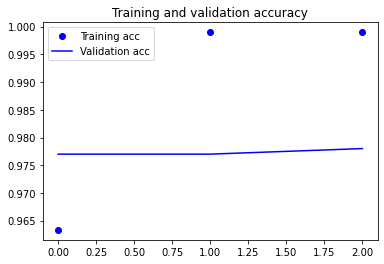

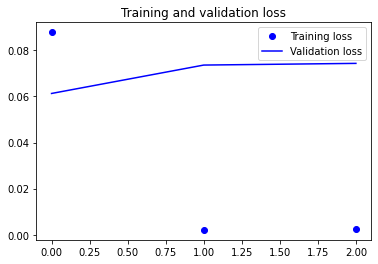

In [48]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [52]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv_pw_11':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [53]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0   

In [ ]:
hist = model.fit(traindata, validation_data=validation_data, epochs=3, steps_per_epoch=int(traindata.samples/Batch_size), callbacks=[reduce_lr, model_checkpoint_callback1])